In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds


In [4]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteKZHUVZ/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteKZHUVZ/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [5]:
train_ds, valid_ds = ds['train'], ds['validation']

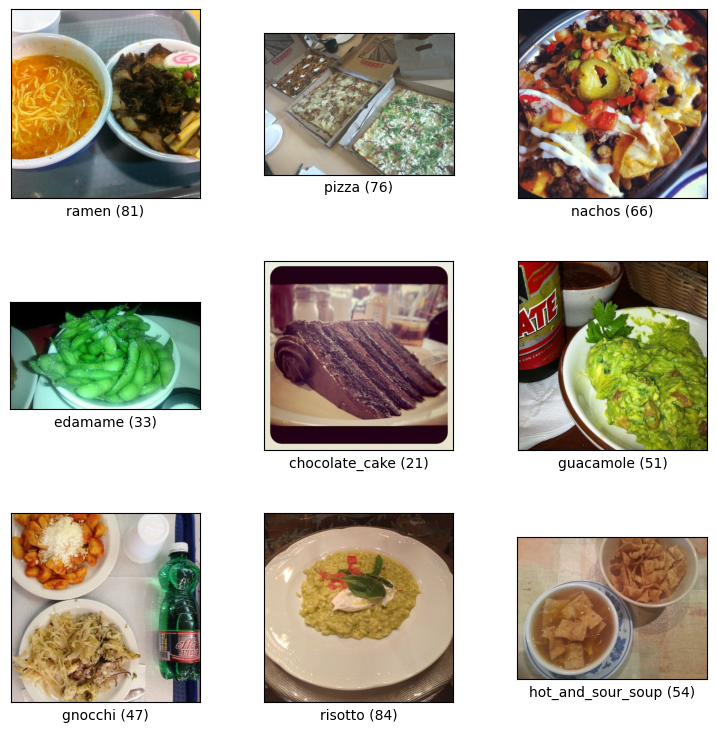

In [6]:
fig = tfds.show_examples(train_ds, ds_info)

In [7]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)

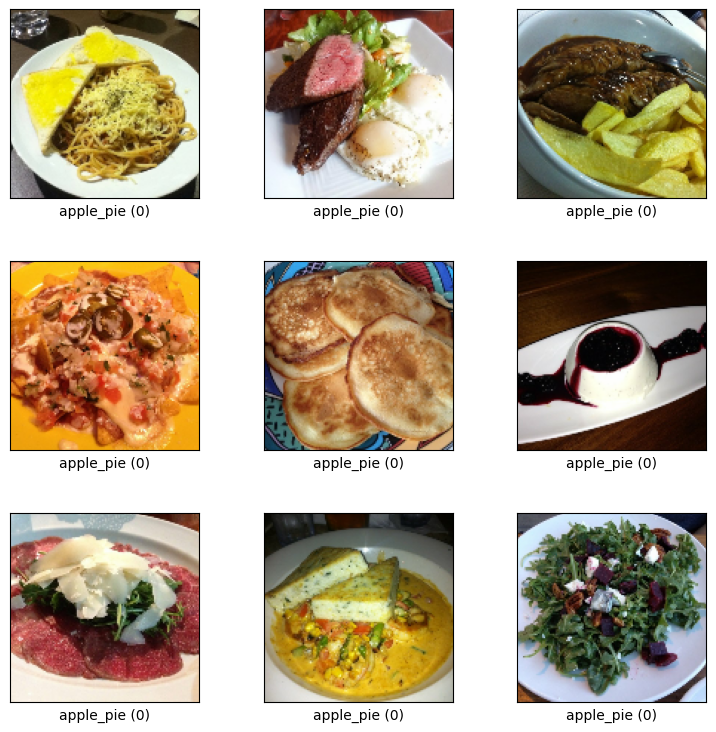

In [8]:
fig = tfds.show_examples(train_ds, ds_info)

In [13]:
train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda image, label: label ==1).repeat(3)
train_nothotdogs = train_ds.filter(lambda image, label: label ==0)

In [14]:
valid_hotdogs = valid_ds.filter(lambda _, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda _, label: label == 0)

In [15]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [16]:
for image_batch, lable_batch in train_ds.take(1):
  print(image_batch)
  print(lable_batch)

tf.Tensor(
[[[[ 21  25  30]
   [ 23  25  30]
   [ 23  24  28]
   ...
   [ 37  35  48]
   [ 45  40  53]
   [ 56  41  53]]

  [[ 26  27  31]
   [ 23  23  28]
   [ 26  25  31]
   ...
   [ 37  36  47]
   [ 42  40  50]
   [ 52  43  51]]

  [[ 37  30  29]
   [ 34  27  27]
   [ 35  29  32]
   ...
   [ 42  39  50]
   [ 40  36  45]
   [ 48  43  49]]

  ...

  [[145  93  90]
   [144  89  88]
   [146  87  86]
   ...
   [ 33  25  36]
   [ 44  41  49]
   [ 42  39  43]]

  [[150  97  95]
   [143  88  86]
   [147  88  88]
   ...
   [ 45  34  43]
   [ 49  42  51]
   [ 61  55  61]]

  [[152  99  97]
   [148  93  92]
   [152  93  93]
   ...
   [ 50  34  44]
   [ 43  31  41]
   [ 51  39  47]]]


 [[[129 168 197]
   [130 169 198]
   [129 168 197]
   ...
   [252 251 247]
   [252 251 247]
   [252 251 247]]

  [[128 168 195]
   [130 170 197]
   [127 166 194]
   ...
   [252 251 247]
   [252 251 247]
   [252 251 247]]

  [[127 167 193]
   [128 168 194]
   [123 163 189]
   ...
   [252 251 247]
   [252 251 247]


In [17]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [18]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/5
280/280 [==============================] - 375s 1s/step - loss: 0.5611 - accuracy: 0.7487 - val_loss: 0.6738 - val_accuracy: 0.6954
Epoch 2/5
280/280 [==============================] - 388s 1s/step - loss: 0.5016 - accuracy: 0.7936 - val_loss: 0.7148 - val_accuracy: 0.6660
Epoch 3/5
280/280 [==============================] - 371s 1s/step - loss: 0.4361 - accuracy: 0.8380 - val_loss: 0.7563 - val_accuracy: 0.6680
Epoch 4/5
280/280 [==============================] - 374s 1s/step - loss: 0.3812 - accuracy: 0.8735 - val_loss: 0.7601 - val_accuracy: 0.6747
Epoch 5/5
280/280 [==============================] - 373s 1s/step - loss: 0.3246 - accuracy: 0.9062 - val_loss: 0.8727 - val_accuracy: 0.6473


In [21]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

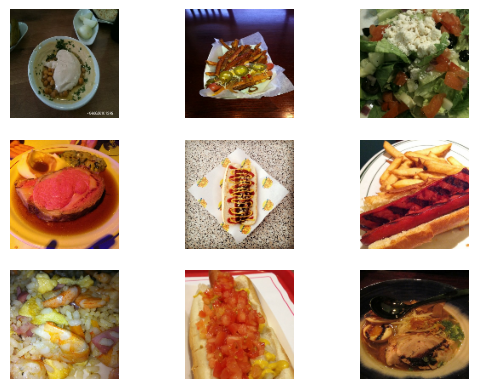

In [22]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [23]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 1, 0, 0, 1, 1, 0, 1, 0], dtype=int32)>